In [14]:
import numpy as np
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

In [136]:
from numpy.random import gamma, randn, rand
from scipy.special import gammaln


class BaysianChangepointDetector():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.):
        self.mu0    = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0  = np.array([beta0])

        self.muT    = np.array([mu0])
        self.kappaT = np.array([kappa0])
        self.alphaT = np.array([alpha0])
        self.betaT  = np.array([beta0])

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0


    def add_data(self, data):

        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.muT,
                               self.betaT*(self.kappaT+1)/(self.alphaT*self.kappaT),
                               2 * self.alphaT)

        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)

        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                            * predictive * hazard).sum()

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()
        #print data, predictive, self.beliefs[:,self.runlength+1]
        #8. Update parameters
        muT0    = np.concatenate([self.mu0, (self.kappaT*self.muT + data) / (self.kappaT+1)])
        kappaT0 = np.concatenate([self.kappa0, self.kappaT + 1])
        alphaT0 = np.concatenate([self.alpha0, self.alphaT + 0.5])
        betaT0  = np.concatenate([self.beta0, self.kappaT + (self.kappaT*(data-self.muT)**2)
                                  / (2*(self.kappaT+1))])
        self.muT     = muT0
        self.kappaT  = kappaT0
        self.alphaT  = alphaT0
        self.betaT   = betaT0
        
        print data
        print 'mu', self.muT
        print 'pred:',predictive
        print 'belief',self.beliefs[0:self.runlength+2,self.runlength+1]
        print '==================='
        #9. not implemented, we don't want to make predictions for the next datum

        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums


    def __compute_predictive(self, data, mu, var, nu):
        r = np.asarray(nu*1.0)
        c = np.exp(gammaln((r+1)/2) - gammaln(r/2))
        c /= np.sqrt(r * np.pi * var) * (1+((data-mu)**2)/(r*var))**((r+1)/2)
        return c

    def __compute_hazard(self):
        _lambda = 250
        probability = np.ones(1) / _lambda
        return probability


In [3]:
def markovTransition(p):
        if np.random.rand() < 0.95 or n==1:
            return p
        else:
            newState = np.random.randint(0, high=n)
            while newState == p:
                newState = np.random.randint(0, high=n)
            p = newState                
        return p

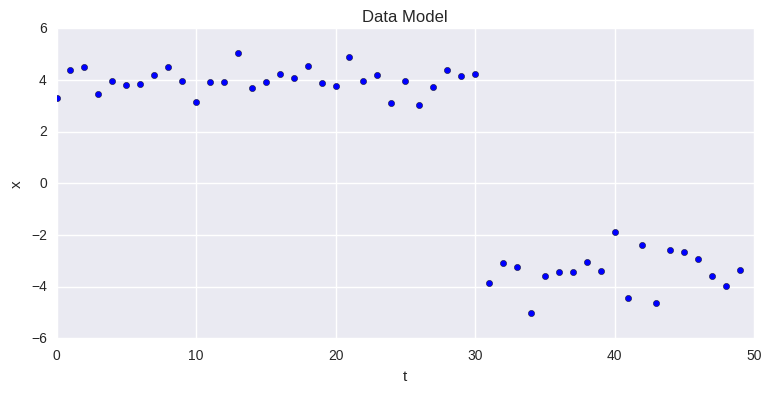

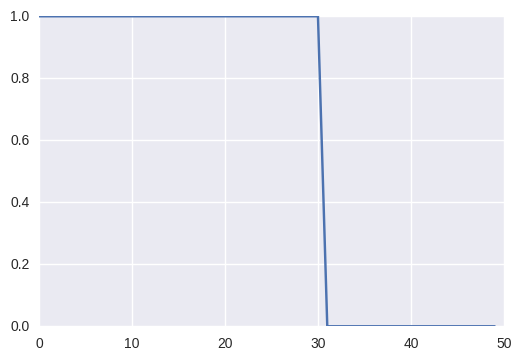

In [32]:
n = 3
currState = np.random.randint(3)
states = []
data = []
for i in range(50):
    currState = markovTransition(currState)
    states.append(currState)
    if currState == 0:
        x = np.random.normal(loc=-3 , scale=1)
    elif currState == 1:
        x = np.random.normal(loc=4 , scale=0.5)
    elif currState == 2:
        x = np.random.normal(loc=1 , scale=0.4)
    data.append(x)
    
    
plt.figure(figsize=(9,4))
plt.scatter(range(len(data)),data)
plt.xlim( 0, len(data) )
plt.title('Data Model')
plt.ylabel('x')
plt.xlabel('t')

plt.show()
plt.plot(range(len(data)), states)

In [297]:
bcp = BaysianChangepointDetector()
for i in data:
    bcp.add_data(i)

-4.67423927678
mu [ 0.         -2.33711964]
pred: [ 0.01521867]
belief [ 0.004  0.996]
-4.23620149047
mu [ 0.         -2.11810075 -2.97014692]
pred: [ 0.01945426  0.10278695]
belief [  4.00000000e-03   7.56496052e-04   9.95243504e-01]
-3.57790482862
mu [ 0.         -1.78895241 -2.60470211 -3.1220864 ]
pred: [ 0.02904101  0.12300559  0.23087519]
belief [  4.00000000e-03   5.03070830e-04   4.02985081e-04   9.95093944e-01]
-4.89036911209
mu [ 0.         -2.44518456 -2.82275798 -3.17611886 -3.47574294]
pred: [ 0.01355992  0.05767778  0.07160809  0.1107873 ]
belief [  4.00000000e-03   4.89531681e-04   2.61879524e-04   2.60444310e-04
   9.94988144e-01]
-3.29202634379
mu [ 0.         -1.64601317 -2.72746515 -2.94007507 -3.19930035 -3.44512351]
pred: [ 0.03499384  0.13006841  0.19352073  0.2402903   0.26163155]
belief [  4.00000000e-03   5.34902432e-04   2.43318751e-04   1.93665375e-04
   2.39152014e-04   9.94788961e-01]
6.73346023456
mu [ 0.          3.36673012  1.14714463 -0.36223381 -1.0053

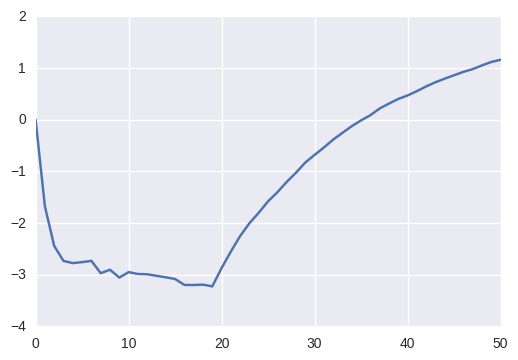

In [130]:
plt.plot(bcp.muT)

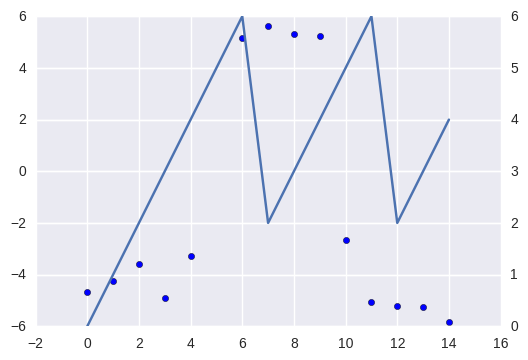

In [298]:
fig, ax1 = plt.subplots()
ax1.set_ylim([-6,6])
plt.scatter(range(len(data)),data)
ax2 = ax1.twinx()
ax2.plot(range(len(bcp.maximums)),bcp.maximums)

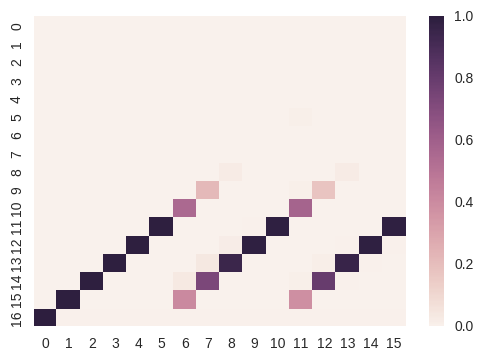

In [299]:
sns.heatmap(bcp.beliefs[::-1])

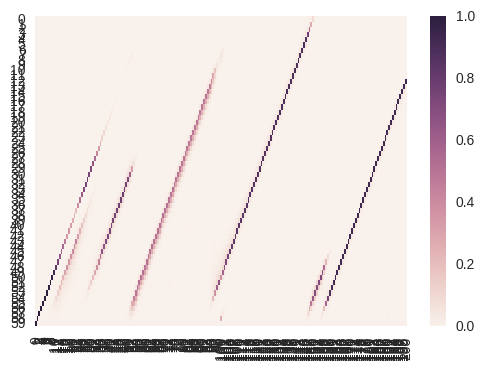

In [23]:
a = bcp.beliefs[:60,:]
sns.heatmap(a[::-1])

In [315]:
from numpy.random import gamma, randn, rand
from scipy.special import gammaln


class BaysianChangepointDetector1Prior():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.):
        self.mu = np.zeros(1)
        self.var =1

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0


    def add_data(self, data):

        
        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.mu, np.ones(len(self.mu)))
        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)
        
        statePred = scipy.stats.norm(5,1).pdf(data)
        
        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                           * predictive * hazard).sum() + (statePred * hazard)
        
        newMu = np.zeros(1)
        #if we belief its a change point
        if np.argmax(self.beliefs[:,self.runlength+1]) == 0:
            #if the prior state is more likely then just a new state
            if (self.beliefs[0:self.runlength+1,self.runlength] * predictive * hazard).sum() < statePred:
                newMu += 5#set new mu to prior state
            


                                           

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()

        #8. Update parameters
        #1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        mu = 1.0/(1.0/1 + 1) *(data + self.mu/1)
        self.mu = np.concatenate([newMu, mu])
        
        
        #print data
        #print 'mu', self.mu
        #print 'pred:',predictive
        #print 'belief',self.beliefs[0:self.runlength+2,self.runlength+1]
        #print '==================='
        
        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums
    
    def __computeTheta(self, _x, _mu, _var, _z):
        #compute updated var
        var = 1.0/(1.0/_var + 1)
        #compute updated mean

        mu = 1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        #return mu,var
        
        return mu

    def __compute_predictive(self, data, mu, var):
        return scipy.stats.norm(mu,var).pdf(data)

    def __compute_hazard(self):
        _lambda = 20
        probability = np.ones(1) / _lambda
        return probability
    


In [211]:
def TestData(mean=[5,1], var=[1,1], n=10, skips=5):
    cp = [1]
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):
        cp.append((i+1)*n+1)
        data = np.append(data, np.random.normal(mean[i%len(mean)],var[i%len(var)],n))
    return data

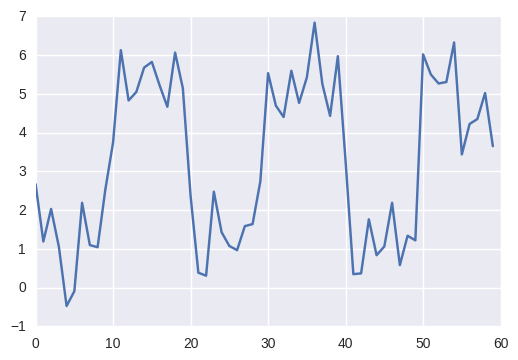

In [212]:
data = TestData()
plt.plot(data)

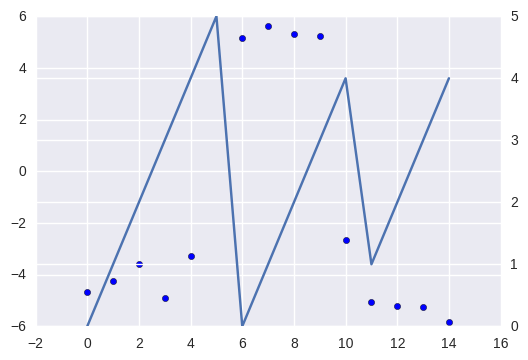

In [295]:
bcp1 = BaysianChangepointDetector1Prior()
for i in data:
    bcp1.add_data(i)
fig, ax1 = plt.subplots()
ax1.set_ylim([-6,6])
plt.scatter(range(len(data)),data)
ax2 = ax1.twinx()
ax2.plot(range(len(bcp1.maximums)),bcp1.maximums)

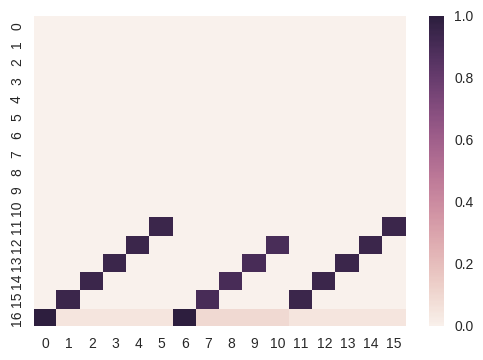

In [296]:
sns.heatmap(bcp1.beliefs[::-1])

In [314]:
from numpy.random import gamma, randn, rand
from scipy.special import gammaln


class BaysianChangepointDetector2Prior():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.):
        self.mu = np.zeros(1)
        self.var =1

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0
        
        M = np.matrix([[0.9, 0.1],[0.1, 0.9]])
        self.filter = AndreasBayesFilterSOFT(2, M)


    def add_data(self, data):
        
        self.filter.update(data)
        
        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.mu, np.ones(len(self.mu)))
        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)
        
        z = [s['unnormZ'] for s in self.filter.stateList]
        z = np.array(z)
        
        z[0] = scipy.stats.norm(5,1).pdf(data)
        z[1] = scipy.stats.norm(-5,1).pdf(data)
        
        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                           * predictive * hazard).sum() + (z.max() * hazard)
        
        newMu = np.zeros(1)
        #if we belief its a change point
        if np.argmax(self.beliefs[:,self.runlength+1]) == 0:
            if (self.beliefs[0:self.runlength+1,self.runlength] * predictive * hazard).sum() < z.max():
                print '-----------------------------------prior state'
                a = [5,-5]
                newMu[0] = a[np.argmax(z)]                                           

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()

        #8. Update parameters
        mu = 1.0/(1.0/1 + 1) *(data + self.mu/1)
        self.mu = np.concatenate([newMu, mu])
        
        
        print data
        print 'mu', self.mu
        print 'pred:',predictive
        print 'belief',self.beliefs[0:self.runlength+2,self.runlength+1]
        print 'z', z
        print '==================='
        
        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums
    
    def __computeTheta(self, _x, _mu, _var, _z):
        var = 1.0/(1.0/_var + 1)
        mu = 1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        return mu

    def __compute_predictive(self, data, mu, var):
        return scipy.stats.norm(mu,var).pdf(data)

    def __compute_hazard(self):
        _lambda = 20
        probability = np.ones(1) / _lambda
        return probability
    


In [286]:
def TestData(mean=[5,-4], var=[1,1], n=5, skips=2):
    cp = [1]
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):
        cp.append((i+1)*n+1)
        data = np.append(data, np.random.normal(mean[i%len(mean)],var[i%len(var)],n))
    return data
data = TestData()

-----------------------------------prior state
-4.67423927678
mu [-5.         -2.33711964]
pred: [  7.18730026e-06]
belief [  9.99639182e-01   3.60817854e-04]
z [  1.89628295e-21   3.78326175e-01]
-4.23620149047
mu [ 0.         -4.61810075 -3.28666056]
pred: [ 0.2980087   0.06573035]
belief [  9.52502151e-02   9.04677761e-01   7.20237433e-05]
z [  1.19299774e-19   2.98008695e-01]
-3.57790482862
mu [ 0.         -1.78895241 -4.09800279 -3.4322827 ]
pred: [ 0.0006624   0.23224967  0.38237627]
belief [  8.17014344e-02   2.75634946e-04   9.17902617e-01   1.20313458e-04]
z [  4.19873136e-17   1.45131381e-01]
-4.89036911209
mu [ 0.         -2.44518456 -3.33966076 -4.49418595 -4.1613259 ]
pred: [  2.55669906e-06   3.25250016e-03   2.91457602e-01   1.37800743e-01]
belief [  1.15545796e-01   6.90532209e-07   2.96364548e-06   8.84395743e-01
   5.48075531e-05]
z [  2.28926985e-22   3.96552040e-01]
-3.29202634379
mu [ 0.         -1.64601317 -2.86860545 -3.31584355 -3.89310615 -3.72667612]
pred: [ 0

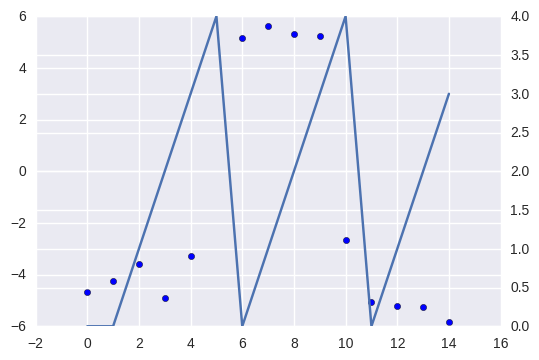

In [310]:

bcp2 = BaysianChangepointDetector2Prior()
for i in data:
    bcp2.add_data(i)
fig, ax1 = plt.subplots()
ax1.set_ylim([-6,6])
plt.scatter(range(len(data)),data)
ax2 = ax1.twinx()
ax2.plot(range(len(bcp2.maximums)),bcp2.maximums)

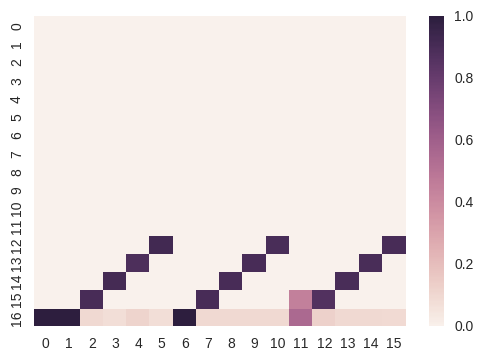

In [311]:
sns.heatmap(bcp2.beliefs[::-1])

In [215]:
class AndreasBayesFilterSOFT(object):   
    def __init__(self, n, M):       
        self.M = M
        self.stateList = []
        self.prevZMax = -2
        for i in range(n):
            theta = [np.random.uniform(-3, 3),1]#TODO
            self.stateList.append(self.initState(1.0/n, theta))
        
    def initState(self, z, theta):
        return {'z':z, 'theta':theta, 'likelihood': [theta[0],1]}
        
    def computeTheta(self, _x, _theta, _z):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _z) * (_z*_x + theta[0]/theta[1])
        return theta
    
    def update(self, _x): 
        zSum = 0
        zMax = 0
        zMaxIndex = -1
        for i,s in enumerate(self.stateList):
            likelihood = scipy.stats.norm(s['likelihood'][0], s['likelihood'][1]).pdf(_x)
            transitionProb = 0
            for k,j in enumerate(self.M[:,i]):
                sTemp = self.stateList[k]
                transitionProb +=  sTemp['z'] * j.item(0) * scipy.stats.norm(sTemp['theta'][0], sTemp['theta'][1]).pdf(sTemp['likelihood'][0])
            unnormZ = likelihood * transitionProb
            s['unnormZ'] = unnormZ
            zSum += unnormZ 
            if unnormZ > zMax:
                zMax = unnormZ
                zMaxIndex = i 
        #normalising z
        for s in self.stateList:
            s['z'] = s['unnormZ']/zSum
            #update state of zMax
            s['theta'] = self.computeTheta(_x, s['theta'], s['z'])
            s['likelihood'][0] = s['theta'][0]   
            
        z = [x['z'] for x in self.stateList]
        mean = [x['likelihood'][0] for x in self.stateList]
        var = [x['likelihood'][1] for x in self.stateList]
        cpbool = zMaxIndex != self.prevZMax
        self.prevZMax = zMaxIndex        
        return z, mean, var, cpbool
    
    def run(self,data):
        z = []
        mean = []
        var = []
        cp = []
        for t,d in enumerate(data):
            zi, mi, vari, cpbool = self.update(d)
            z.append(list(zi))
            mean.append(list(mi))
            var.append(list(vari))
            if cpbool:
                cp.append(t+1)
        return z, mean, var, cp

In [316]:
from numpy.random import gamma, randn, rand
from scipy.special import gammaln


class BaysianChangepointDetectorGaussFilter():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.):
        self.mu = np.zeros(1)
        self.var =1

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0
        
        M = np.matrix([[0.9, 0.1],[0.1, 0.9]])
        self.filter = AndreasBayesFilterSOFT(2, M)


    def add_data(self, data):
        
        self.filter.update(data)
        
        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.mu, np.ones(len(self.mu)))
        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)
        
        z = [s['unnormZ'] for s in self.filter.stateList]
        z = np.array(z)
        
        z[0] = scipy.stats.norm(self.filter.stateList[0]['theta'][0],1).pdf(data)
        z[1] = scipy.stats.norm(self.filter.stateList[1]['theta'][0],1).pdf(data)
        zMaxVar = self.filter.stateList[np.argmax(z)]['theta'][1]
        #z[0] = scipy.stats.norm(5,1).pdf(data)
        #z[1] = scipy.stats.norm(-5,1).pdf(data)
        
        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                           * predictive * hazard).sum() + (1-zMaxVar)*(z.max() * hazard)
        
        newMu = np.zeros(1)
        #if we belief its a change point
        if np.argmax(self.beliefs[:,self.runlength+1]) == 0:
            #if the prior state is more likely then just a new state
            if (self.beliefs[0:self.runlength+1,self.runlength] * predictive * hazard).sum() < (1-zMaxVar)*z.max():
                newMu[0] = self.filter.stateList[np.argmax(z)]['theta'][0]#set new mu to prior 
                print '------------------------------', newMu

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()

        #8. Update parameters
        #1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        mu = 1.0/(1.0/1 + 1) *(data + self.mu/1)
        self.mu = np.concatenate([newMu, mu])
        
        
        print data
        print 'mu', self.mu
        print 'pred:',predictive
        print 'belief',self.beliefs[0:self.runlength+2,self.runlength+1]
        print 'z', z
        print '==================='
        
        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums
    
    def __computeTheta(self, _x, _mu, _var, _z):
        #compute updated var
        var = 1.0/(1.0/_var + 1)
        #compute updated mean

        mu = 1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        #return mu,var
        
        return mu

    def __compute_predictive(self, data, mu, var):
        return scipy.stats.norm(mu,var).pdf(data)

    def __compute_hazard(self):
        _lambda = 20
        probability = np.ones(1) / _lambda
        return probability
    


------------------------------ [-2.01906647]
-4.67423927678
mu [-2.01906647 -2.33711964]
pred: [  7.18730026e-06]
belief [ 0.97731093  0.02268907]
z [  2.36981045e-08   1.17499082e-02]
-4.23620149047
mu [ 0.         -3.12763398 -3.28666056]
pred: [ 0.03415718  0.06573035]
belief [ 0.13296602  0.82995544  0.03707854]
z [  2.69447097e-07   1.00110940e-01]
-3.57790482862
mu [ 0.         -1.78895241 -3.3527694  -3.4322827 ]
pred: [ 0.0006624   0.36048301  0.38237627]
belief [  8.17320362e-02   2.58024749e-04   8.76475005e-01   4.15349336e-02]
z [  7.25080070e-06   2.88846237e-01]
-4.89036911209
mu [ 0.         -2.44518456 -3.33966076 -4.12156926 -4.1613259 ]
pred: [  2.55669906e-06   3.25250016e-03   1.22328533e-01   1.37800743e-01]
belief [  7.75302289e-02   1.70673738e-06   6.85446336e-06   8.75713553e-01
   4.67476570e-02]
z [  6.65444022e-09   8.42665206e-02]
-3.29202634379
mu [ 0.         -1.64601317 -2.86860545 -3.31584355 -3.7067978  -3.72667612]
pred: [ 0.00176844  0.27873074  0.39

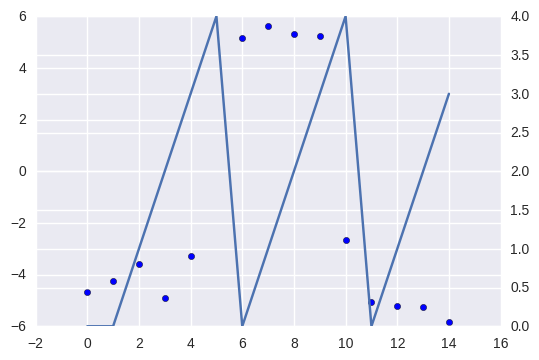

In [317]:
bcp2 = BaysianChangepointDetectorGaussFilter()
for i in data:
    bcp2.add_data(i)
fig, ax1 = plt.subplots()
ax1.set_ylim([-6,6])
plt.scatter(range(len(data)),data)
ax2 = ax1.twinx()
ax2.plot(range(len(bcp2.maximums)),bcp2.maximums)

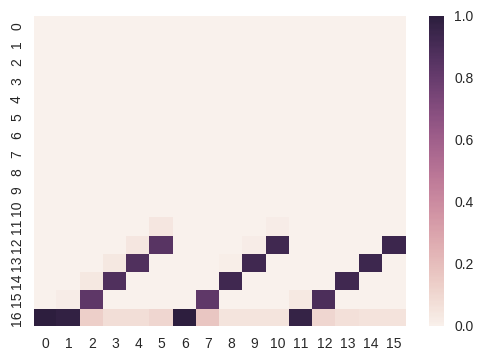

In [319]:
sns.heatmap(bcp2.beliefs[::-1])